<a href="https://colab.research.google.com/github/doankhuong0411/modelling_test/blob/main/MSN_stock_analysis_and_prediton_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task:
*   Load data, clean and transform
*   Data Preprocessing
*   Data Visualization
*   Data Modelling
*   Test Model



In [ ]:
!pip install pandas_ta

In [ ]:
# importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta

import matplotlib.colors
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode

temp = dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), width=800))
colors=px.colors.qualitative.Plotly

In [ ]:
# Connect to google collab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#load data
df = pd.read_csv("/content/drive/MyDrive/Finpros_test/MSN.csv")

In [ ]:
print(df.shape)
print(df.dtypes)
df.head(5)

(135354, 8)
Ticker            object
Date/Time         object
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
Open Interest      int64
dtype: object


,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,MSN,12/25/2017 9:15,73.1,73.1,73.1,73.1,4210,0
1,MSN,12/25/2017 9:16,73.0,73.0,73.0,73.0,5000,0
2,MSN,12/25/2017 9:18,73.5,73.5,73.5,73.5,210,0
3,MSN,12/25/2017 9:20,73.2,73.5,73.1,73.1,2050,0
4,MSN,12/25/2017 9:21,73.0,73.0,73.0,73.0,1380,0


In [ ]:
# transfrom and clean data
df.rename(columns={'Date/Time': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %H:%M')

#Group the data by date
data = df.groupby(df['Date'].dt.date).agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
}).reset_index()

# create volatility
data['volatility'] = data['Close'].shift(-1) - data['Close']
data['volatility'] = data['volatility'].shift(1)

data.head()

,Date,Open,High,Low,Close,Volume,volatility
0,2017-12-25,73.1,75.4,73.0,74.2,207370,NaN
1,2017-12-26,74.9,75.5,74.3,75.5,403710,1.3
2,2017-12-27,74.9,75.7,74.8,75.0,517920,-0.5
3,2017-12-28,75.0,76.0,74.5,75.7,377030,0.7
4,2017-12-29,76.0,77.0,76.0,76.7,226880,1.0


## 2. Data visualization (trực quan hóa dữ liệu)

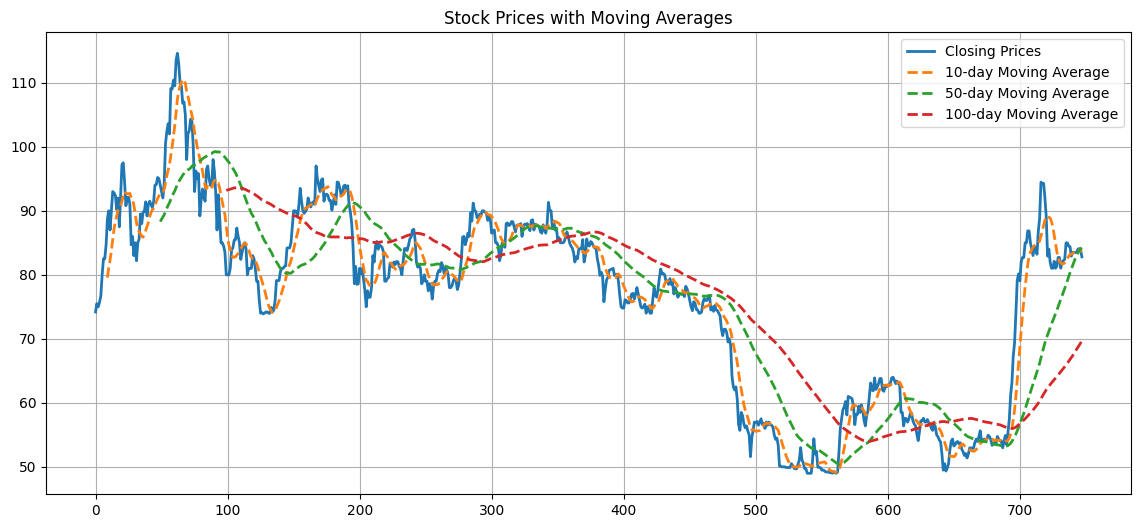

In [ ]:
ma_days = [10, 50, 100]

# Calculate moving averages
for ma_day in ma_days:
    data[f'MA{ma_day}'] = data['Close'].rolling(window=ma_day).mean()

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(data['Close'], label='Closing Prices', linewidth=2)

# Plot each MA
for ma_day in ma_days:
    plt.plot(data[f'MA{ma_day}'], label=f'{ma_day}-day Moving Average', linestyle='--', linewidth=2)

plt.title('Stock Prices with Moving Averages')
plt.legend()
plt.grid(True)
plt.show()

# remove column after visualize
data.drop(['MA10', 'MA50', 'MA100'], axis=1, inplace=True)

In [ ]:
# MSN Market Analysis
data_date = data.Date.unique()
returns = data.groupby('Date')['volatility'].mean().rename('Average Return')
close_avg = data.groupby('Date')['Close'].mean().rename('Closing Price')
vol_avg = data.groupby('Date')['Volume'].mean().rename('Volume')

fig = make_subplots(rows=3, cols=1,
                    shared_xaxes=True)

for i, j in enumerate([returns, close_avg, vol_avg]):
    fig.add_trace(go.Scatter(x=data_date, y=j, mode='lines',
                             name=j.name, marker_color=colors[i]), row=i+1, col=1)

fig.update_xaxes(rangeslider_visible=False,
                 rangeselector=dict(
                     buttons=list([
                         dict(count=6, label="6m", step="month", stepmode="backward"),
                         dict(count=1, label="1y", step="year", stepmode="backward"),
                         dict(count=2, label="2y", step="year", stepmode="backward"),
                         dict(step="all")])),
                 row=1,col=1)

fig.update_layout(template=temp, title='MSN Market Average Stock Return, Closing Price, and Shares Traded',
                  hovermode='x unified', height=700, width=900,
                  yaxis1=dict(title='Stock Return'),
                  yaxis2_title='Closing Price', yaxis3_title='Shares Traded',
                  showlegend=False)
fig.show()

In [ ]:
#RSI được tính dựa trên 14 giá đóng cửa liên tiếp.
data['RSI'] = ta.rsi(data.Close, length=14)

#Tính toán Trung bình Động Exponential
data['EMAF'] = ta.ema(data.Close, length=20)
data['EMAM'] = ta.ema(data.Close, length=100)
data['EMAS'] = ta.ema(data.Close, length=150)

data['Target'] = data['Close'] - data['Open']
data['Target'] = data['Target'].shift(-1)

data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]

data['TargetNextClose'] = data['Close'].shift(-1)


data.dropna(inplace=True)
data.drop(['volatility', 'Volume'], axis=1, inplace=True)
data.reset_index(inplace=True)

In [ ]:
data.head()

,index,Date,Open,High,Low,Close,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
0,149,2018-08-06,85.0,88.4,84.5,87.4,77.250179,81.313820,84.988393,88.932000,2.6,1,90.0
1,150,2018-08-07,87.4,90.6,87.0,90.0,81.361383,82.141076,85.087633,88.946146,0.0,0,90.0
2,151,2018-08-08,90.0,90.0,88.5,90.0,81.361383,82.889545,85.184908,88.960104,-0.1,0,89.9
3,152,2018-08-09,90.0,90.9,88.9,89.9,80.710776,83.557207,85.278276,88.972553,0.3,1,89.0
4,153,2018-08-10,88.7,89.5,87.8,89.0,74.905274,84.075568,85.351973,88.972917,2.6,1,90.9


In [ ]:
data_set = data.iloc[:, 5:13]
pd.set_option('display.max_columns', None)

data_set.head()

,Close,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
0,87.4,77.250179,81.313820,84.988393,88.932000,2.6,1,90.0
1,90.0,81.361383,82.141076,85.087633,88.946146,0.0,0,90.0
2,90.0,81.361383,82.889545,85.184908,88.960104,-0.1,0,89.9
3,89.9,80.710776,83.557207,85.278276,88.972553,0.3,1,89.0
4,89.0,74.905274,84.075568,85.351973,88.972917,2.6,1,90.9


In [ ]:
print(data_set.shape)
print(data_set.dtypes)

(598, 8)
Close              float64
RSI                float64
EMAF               float64
EMAM               float64
EMAS               float64
Target             float64
TargetClass          int64
TargetNextClose    float64
dtype: object


## 3. Build and Train a Model

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

#normalize data using MinMaxScaler (chuẩn hóa dữ liệu)
scaler = MinMaxScaler(feature_range=(0, 1))
data_set_scaled = scaler.fit_transform(data_set)
print(data_set_scaled)

[[0.8        0.83201627 0.73404251 ... 0.66475879 1.         0.85416667]
 [0.85416667 0.88487627 0.75319767 ... 0.4521668  0.         0.85416667]
 [0.85416667 0.88487627 0.77052852 ... 0.44399019 0.         0.85208333]
 ...
 [0.72916667 0.53703275 0.78412996 ... 0.48487326 1.         0.73125   ]
 [0.73125    0.54223219 0.78550394 ... 0.35404742 0.         0.725     ]
 [0.725      0.52267711 0.78608549 ... 0.37040065 0.         0.70416667]]


In [ ]:
# Trích xuất đặc trưng từ dữ liệu để chuẩn bị cho mô hình
X = []

backcandles = 30
print(data_set_scaled.shape[0])
for j in range(data_set_scaled[0].size):
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-backcandles:i, j])

# Di chuyển trục từ vị trí 0 đến vị trí 2
X=np.moveaxis(X, [0], [2])

X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))

print(X)
print(X.shape)
print(y)
print(y.shape)

598
[[[0.8        0.83201627 0.73404251 ... 0.66475879 1.         0.85416667]
  [0.85416667 0.88487627 0.75319767 ... 0.4521668  0.         0.85416667]
  [0.85416667 0.88487627 0.77052852 ... 0.44399019 0.         0.85208333]
  ...
  [0.90416667 0.54355528 0.97810903 ... 0.38675388 0.         0.8875    ]
  [0.8875     0.50897489 0.97754815 ... 0.49304988 1.         0.8875    ]
  [0.8875     0.50897489 0.97704069 ... 0.33769419 0.         0.85625   ]]

 [[0.85416667 0.88487627 0.75319767 ... 0.4521668  0.         0.85416667]
  [0.85416667 0.88487627 0.77052852 ... 0.44399019 0.         0.85208333]
  [0.85208333 0.87651106 0.7859883  ... 0.47669665 1.         0.83333333]
  ...
  [0.8875     0.50897489 0.97754815 ... 0.49304988 1.         0.8875    ]
  [0.8875     0.50897489 0.97704069 ... 0.33769419 0.         0.85625   ]
  [0.85625    0.44436135 0.97327369 ... 0.38675388 0.         0.87916667]]

 [[0.85416667 0.88487627 0.77052852 ... 0.44399019 0.         0.85208333]
  [0.85208333 0.87

In [ ]:
# chia dữ liệu thành train và test
splitlimit = int(len(X)*0.8)
print(splitlimit)

X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

454
(454, 30, 8)
(114, 30, 8)
(454, 1)
(114, 1)
[[0.87916667]
 [0.90625   ]
 [0.875     ]
 [0.94791667]
 [0.94583333]
 [0.92708333]
 [0.90625   ]
 [0.9125    ]
 [0.93541667]
 [0.9375    ]
 [0.92083333]
 [0.93541667]
 [0.875     ]
 [0.85      ]
 [0.8125    ]
 [0.73958333]
 [0.61666667]
 [0.67291667]
 [0.61458333]
 [0.61666667]
 [0.66666667]
 [0.65      ]
 [0.66666667]
 [0.62916667]
 [0.59375   ]
 [0.54166667]
 [0.59375   ]
 [0.57291667]
 [0.57291667]
 [0.60416667]
 [0.70833333]
 [0.6875    ]
 [0.73958333]
 [0.75416667]
 [0.72916667]
 [0.74375   ]
 [0.73958333]
 [0.73541667]
 [0.72083333]
 [0.625     ]
 [0.625     ]
 [0.63333333]
 [0.6375    ]
 [0.68333333]
 [0.68333333]
 [0.67083333]
 [0.6875    ]
 [0.67916667]
 [0.68958333]
 [0.6875    ]
 [0.67291667]
 [0.66666667]
 [0.64583333]
 [0.69166667]
 [0.73125   ]
 [0.73125   ]
 [0.725     ]
 [0.74166667]
 [0.7625    ]
 [0.76875   ]
 [0.79166667]
 [0.79375   ]
 [0.76041667]
 [0.6875    ]
 [0.67083333]
 [0.67708333]
 [0.66666667]
 [0.61666667]


In [ ]:
from keras.models import Sequential, Model
from keras.layers import LSTM, Dropout, Dense, Input, Activation
from keras import optimizers
import numpy as np

#tf.random.set_seed(20)
np.random.seed(10)

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')

inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)

# Compile the model
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')

# train model
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
28/28 [==============================] - 4s 80ms/step - loss: 0.0803 - val_loss: 0.0043
Epoch 2/30
28/28 [==============================] - 3s 92ms/step - loss: 0.0066 - val_loss: 0.0037
Epoch 3/30
28/28 [==============================] - 2s 74ms/step - loss: 0.0036 - val_loss: 0.0016
Epoch 4/30
28/28 [==============================] - 2s 76ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 5/30
28/28 [==============================] - 2s 77ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 6/30
28/28 [==============================] - 2s 69ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 7/30
28/28 [==============================] - 2s 63ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 8/30
28/28 [==============================] - 2s 77ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 9/30
28/28 [==============================] - 2s 85ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 10/30
28/28 [==============================] - 2s 84ms/step - loss: 0.0022 - val_loss: 0.0010
Epoch 11/

## 4. Đánh giá độ chính xác của mô hình

In [ ]:
y_pred = model.predict(X_test)

# So sánh 10 giá trị dự đoán và thực tế
for i in range(10):
    print(y_pred[i], y_test[i])

#
min_length = min(len(y_train), len(y_pred))
y_train = y_train[:min_length]
y_pred = y_pred[:min_length]

min_length = min(len(y_train), len(y_pred))
y_train = y_train[:min_length]
y_pred = y_pred[:min_length]

#r2
print('Độ phù hợp:',r2_score(y_test, y_pred))
#mae
print('Sai số tuyệt đối trung bình:',mean_absolute_error(y_test, y_pred))
#mae per
print('Phần trăm sai số tuyệt đối trung bình:',mean_absolute_percentage_error(y_test, y_pred))

4/4 [==============================] - 0s 13ms/step
[0.1341305] [0.13958333]
[0.12159128] [0.16666667]
[0.14482369] [0.15]
[0.13716611] [0.125]
[0.1218337] [0.11875]
[0.10560145] [0.10833333]
[0.09300863] [0.10208333]
[0.08254201] [0.0625]
[0.06494583] [0.01041667]
[0.06858666] [0.03125]
Độ phù hợp: 0.9704556188955095
Sai số tuyệt đối trung bình: 0.03579767265111992
Phần trăm sai số tuyệt đối trung bình: 0.25137545870647704


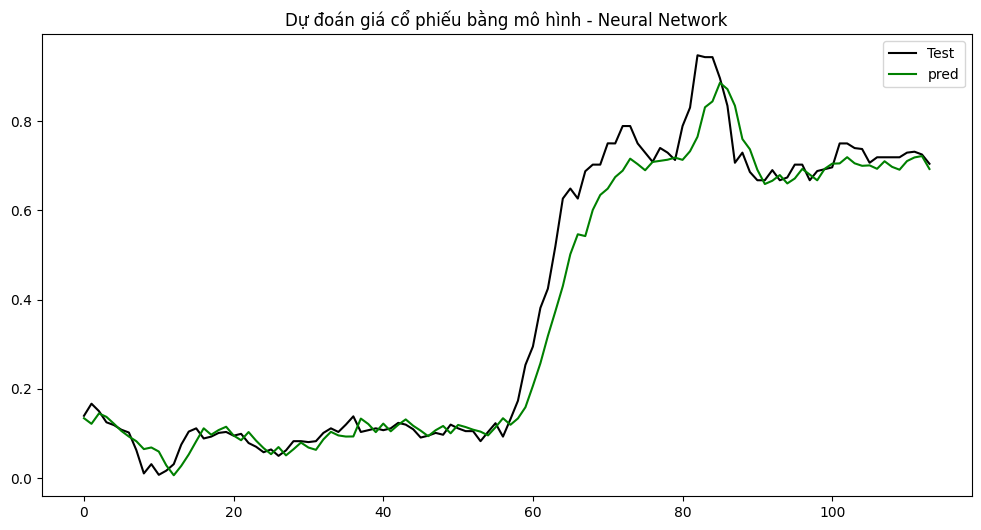

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.title("Dự đoán giá cổ phiếu bằng mô hình - Neural Network")
plt.show()